# Policy Gradient with Baseline

- https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html
- https://spinningup.openai.com/en/latest/algorithms/vpg.html

## Imports

In [1]:
import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn
import torch.distributions as dist
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython import display

### Utilities

In [2]:
def plot_loss(actor_losses, critic_losses, rets):
    display.clear_output(True)

    plt.figure(figsize=(18, 4))

    ax1 = plt.subplot(1, 3, 1)
    ax1.plot(actor_losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Actor Loss')

    ax1 = plt.subplot(1, 3, 2)
    ax1.plot(critic_losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Critic Loss')

    ax2 = plt.subplot(1, 3, 3)
    ax2.plot(rets)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Return')

    plt.show()


def render(env):
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()
    display.clear_output(wait=True)

## Models

In [3]:
class Actor(nn.Module):
    def __init__(self, env, hidden_size=32):
        super().__init__()
        obs_dim = env.observation_space.shape[0]
        acts_dim = env.action_space.n
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, acts_dim),
        )

    def forward(self, obs):
        logits = self.mlp(obs)
        return dist.Categorical(logits=logits)

    def get_action(self, obs):
        return self.forward(obs).sample().item()

    def compute_loss(self, obs, act, adv):
        logp = self.forward(obs).log_prob(act)
        return -(logp * adv).mean()


class Critic(nn.Module):
    def __init__(self, env, hidden_size=32):
        super().__init__()
        obs_dim = env.observation_space.shape[0]
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        self.mse = nn.MSELoss()

    def forward(self, obs):
        return self.mlp(obs).squeeze(-1)

    def get_value(self, obs):
        return self.forward(obs).item()

    def compute_loss(self, obs, rets):
        return self.mse(self.forward(obs), rets)

## Train

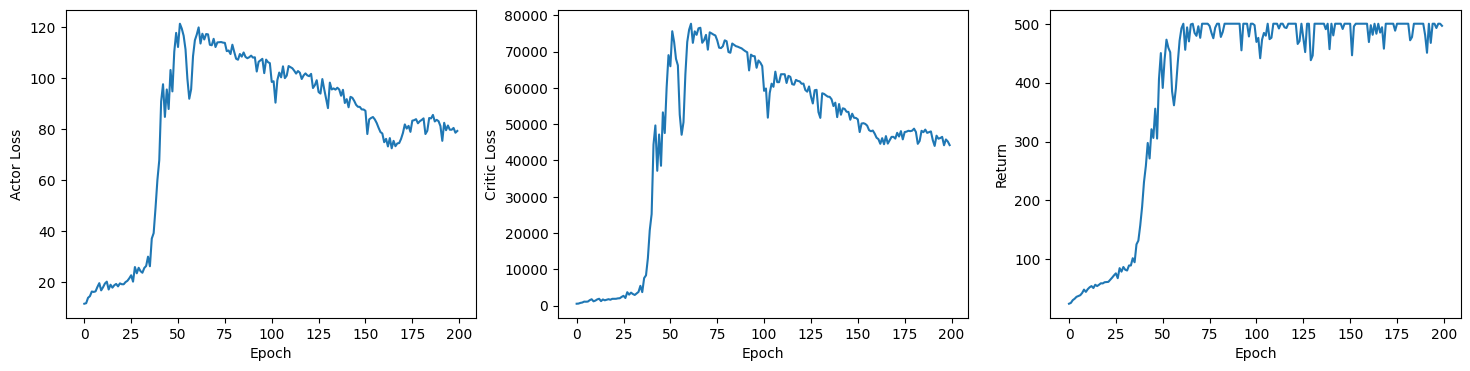

In [4]:
def train():
    batch_obs = []
    batch_acts = []
    batch_rets = []
    batch_advs = []
    episode_rets = []

    obs, _ = env.reset()
    values = []
    rewards = []

    # Collect a batch of data
    actor.eval()
    while True:
        batch_obs.append(obs)

        obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
        act = actor.get_action(obs_tensor)
        value = critic.get_value(obs_tensor)
        obs, reward, terminated, truncated, _ = env.step(act)
        done = terminated or truncated

        batch_acts.append(act)
        values.append(value)
        rewards.append(reward)

        if done:
            # Calculate the future return (reverse, cumulative sum, and reverse again)
            rets = np.array(rewards[::-1]).cumsum()[::-1]
            episode_rets.append(rets[0])
            batch_rets += rets.tolist()
            batch_advs += (rets - np.array(values)).tolist()

            if len(batch_obs) > batch_size:
                break

            obs, _ = env.reset()
            values = []
            rewards = []

    # Update the policy
    actor.train()
    actor_optimizer.zero_grad()
    actor_batch_loss = actor.compute_loss(
        obs=torch.as_tensor(batch_obs, dtype=torch.float32),
        act=torch.as_tensor(batch_acts, dtype=torch.int32),
        adv=torch.as_tensor(batch_advs, dtype=torch.float32),
    )
    actor_batch_loss.backward()
    actor_optimizer.step()
    actor_scheduler.step()

    # Update the value function
    critic.train()
    critic_optimizer.zero_grad()
    critic_batch_loss = critic.compute_loss(
        obs=torch.as_tensor(batch_obs, dtype=torch.float32),
        rets=torch.as_tensor(batch_rets, dtype=torch.float32),
    )
    critic_batch_loss.backward()
    critic_optimizer.step()
    critic_scheduler.step()

    return actor_batch_loss.item(), critic_batch_loss.item(), np.mean(episode_rets)


# Hyperparameters
env_name = 'CartPole-v1'
learning_rate = 1e-2
batch_size = 5000
epochs = 200

# Initialize the environment and the models
env = gym.make(env_name, render_mode='rgb_array')
actor = Actor(env)
critic = Critic(env)
actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
actor_scheduler = optim.lr_scheduler.ExponentialLR(actor_optimizer, gamma=0.995)
critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate)
critic_scheduler = optim.lr_scheduler.ExponentialLR(critic_optimizer, gamma=0.995)

# Train the policy
actor_losses = []
critic_losses = []
rets = []
for epoch in range(epochs):
    actor_loss, critic_loss, ret = train()
    actor_losses.append(actor_loss)
    critic_losses.append(critic_loss)
    rets.append(ret)
    plot_loss(actor_losses, critic_losses, rets)

## Evaluate

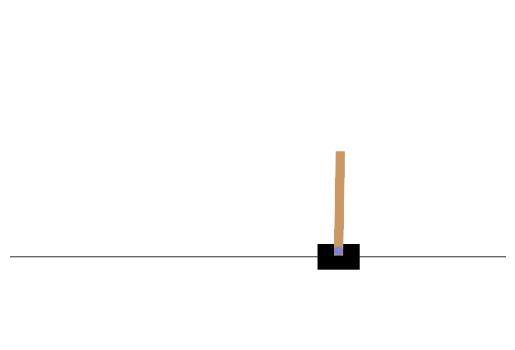

In [42]:
obs, _ = env.reset()
done = False
while not done:
    render(env)
    act = actor.get_action(torch.as_tensor(obs, dtype=torch.float32))
    obs, _, terminated, truncated, _ = env.step(act)
    done = terminated or truncated